In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skopt import BayesSearchCV

from xgboost import XGBClassifier

%matplotlib inline

In [130]:
class BayesSearchCV(BayesSearchCV):
    def _run_search(self, x): raise BaseException('Use newer skopt')

In [59]:
df = pd.read_csv('./data/model12218.csv', index_col = 0)

In [60]:
df.head()

,age,animal_type,dow,fixed_status,gender,group,intake_condition,intake_season,intake_type,mix,simple_color,hour_in,simple_group,shade,given_name,name_freq,days_in_shelter,outcome_type
0,2920,Dog,6,fixed,1,Sporting,Normal,summer,Stray,0,White,12,Sporting,Light,Belle,52,0,Return to Owner
1,330,Dog,3,intact,0,Hound,Normal,spring,Stray,1,Sable,18,Non-Sporting,Light,Runster,1,6,Return to Owner
2,1460,Dog,6,fixed,0,Working,Normal,spring,Stray,1,Yellow,10,Non-Sporting,Light,Rio,22,3,Return to Owner
3,730,Dog,5,fixed,0,Sporting,Normal,winter,Owner Surrender,1,Brown,12,Sporting,Medium,Odin,32,3,Return to Owner
4,730,Dog,3,intact,0,Sporting,Normal,summer,Public Assist,1,Black,14,Sporting,Dark,Mumble,1,5,Return to Owner


In [61]:
df_model = df.copy()

In [62]:
df_model = df_model.drop(labels=['days_in_shelter'], axis=1)

In [63]:
df_model['hour_in'] = df_model['hour_in'].astype('category')

In [64]:
df_model = df_model.drop(labels=['given_name'], axis=1)

In [66]:
df_model = df_model[~df_model.duplicated()]

## Create dummy variables

In [104]:
X = pd.concat([pd.get_dummies(df_model[['animal_type', 'fixed_status', 'group', 'intake_condition',
                              'intake_season', 'intake_type', 'simple_color', 'simple_group',
                              'shade', 'hour_in']]), df_model[['age', 'gender', 'mix', 'name_freq']]], axis=1)

In [108]:
X = pd.concat([X, pd.get_dummies(df_model['dow'])], axis=1)

In [110]:
y = df_model.iloc[:, -1]

In [111]:
X.shape

(63365, 80)

In [112]:
y.shape

(63365,)

In [113]:
le = LabelEncoder()
le.fit(y)

LabelEncoder()

In [114]:
le.classes_

array(['Adoption', 'Died', 'Euthanasia', 'Return to Owner', 'Transfer'],
      dtype=object)

In [115]:
y = le.transform(y)

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 2325)

In [117]:
rf_cv = RandomForestClassifier(n_estimators = 800, max_features='sqrt', max_leaf_nodes=50,
                               max_depth = 100)

rf_cv.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=100, max_features='sqrt', max_leaf_nodes=50,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

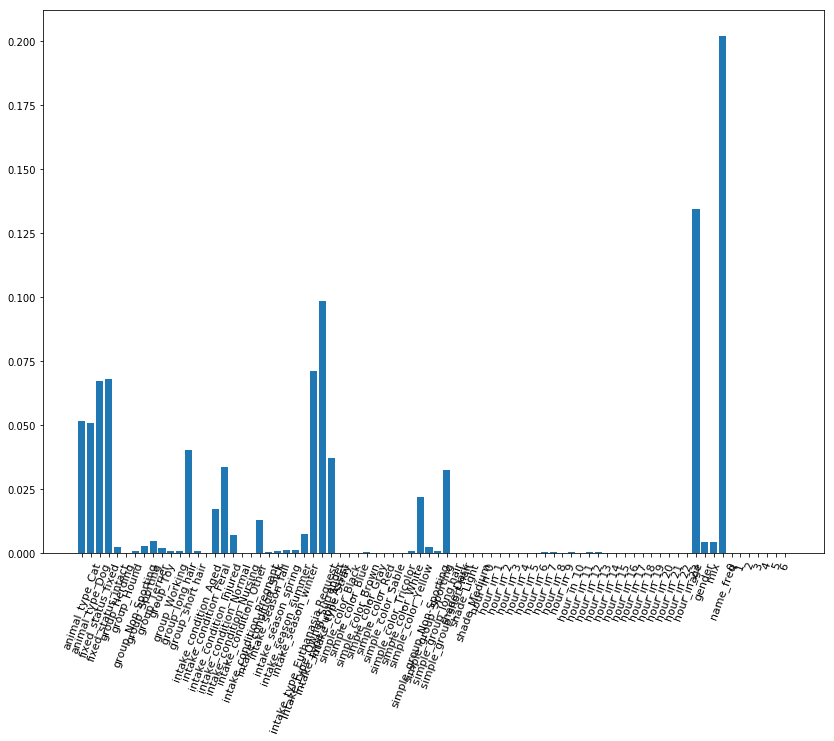

In [120]:
plt.figure(figsize=(14, 10))
plt.bar(list(map(str, X_train.columns.values)), rf_cv.feature_importances_)
plt.xticks(rotation=70, size=11);

In [121]:
rfc = RandomForestClassifier()

tuning_params_rf = {'n_estimators': [300, 800], 'max_features': ['auto'], 'class_weight': ['balanced']}

bs = BayesSearchCV(rfc, tuning_params_rf, n_jobs=-1, n_iter = 10, scoring='f1_micro', cv=3)

bs.fit(X_train, y_train)

BayesSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_iter=10, n_jobs=-1, n_points=1,
       optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=None,
       refit=True, return_train_score=False, scoring='f1_micro',
       search_spaces={'n_estimators': [300, 800], 'max_features': ['auto'], 'class_weight': ['balanced']},
       verbose=0)

In [122]:
bs.best_score_

0.624665951223618

In [123]:
bs.best_params_

{'class_weight': 'balanced', 'max_features': 'auto', 'n_estimators': 754}

## XGBoost hyperparameter tuning

In [82]:
xg = XGBClassifier(n_jobs = -1)

tuning_params = {'max_depth': [5, 90], 'learning_rate': [0, 1], 'min_child_weight': [1, 3, 5],
                'objective': ['multi:softprob']}

bs = BayesSearchCV(xg, tuning_params, cv=3, verbose=True, scoring = 'f1_micro', n_jobs=-1, n_iter = 10)

bs.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  4.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.3min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  4.1min finished


BayesSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_iter=10, n_jobs=-1, n_points=1,
       optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=None,
       refit=True, return_train_score=False, scoring='f1_micro',
       search_spaces={'max_depth': [5, 90], 'learning_rate': [0, 1], 'min_child_weight': [1, 3, 5]},
       verbose=True)

In [83]:
bs.best_params_

{'learning_rate': 1, 'max_depth': 45, 'min_child_weight': 1}

In [84]:
bs.best_score_

0.5939860699029943

In [56]:
pipe = make_pipeline(StandardScaler(), XGBClassifier(learning_rate=1, max_depth=10, min_child_weight=3,
                                                    objective='multi:softprob'))

In [ ]:
gb_pipe = make_pipeline(StandardScaler(), XGBClassifier())

cv = StratifiedKFold(n_splits = 3, shuffle=True)

gb_tuning = {'max_depth': [1, 100], 'learning_rate': [0, 1], 'objective': ['multi:softprob'],
             'reg_alpha': [1e-3, 1e-2, 1e-1, 1, 1e2, 1e3], 'colsample_bytree': [0.2, 0.8],
             'n_estimators': [50, 300]}

gb_bs = BayesSearchCV(xg, tuning_params, cv=cv, verbose=True, scoring = 'neg_log_loss', n_jobs=-1, n_iter = 20)

gb_bs.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


In [58]:
scores

array([0.59838701, 0.60567432, 0.60540419])

In [124]:
rf_pipe = make_pipeline(StandardScaler(),
                        RandomForestClassifier(n_estimators = 800, max_features='sqrt', max_leaf_nodes=200,
                                               max_depth = 100))

rf_scores = cross_val_score(rf_pipe, cv=3, n_jobs=-1, scoring='neg_log_loss', X=X_train, y=y_train)

In [125]:
rf_scores

array([-0.92626643, -0.91915272, -0.91298409])

# Regression

Now I'll train the models used to predict the number of days an animal spends in the shelter.

First I need to isolate the features and response.

In [104]:
df_regress = df.iloc[:, 1:]

In [105]:
df_regress = pd.concat([df_regress, pd.get_dummies(df_regress[['simple_group', 'shade']])], axis=1)\
.drop(labels=['simple_group', 'shade'], axis=1)

In [106]:
df_regress['outcome_type'].value_counts()

Adoption           33455
Transfer           22946
Return to Owner    14938
Euthanasia          2873
Died                 540
Name: outcome_type, dtype: int64

### Adoption regression

In [85]:
df_adopt = df_model[df_model['outcome_type'] == 'Adoption']

In [91]:
df_adopt.head()

,simple_group_Non-Sporting,simple_group_Sporting,simple_group_long hair,simple_group_short hair,shade_Dark,shade_Light,shade_Medium,name_freq,hour,age,...,intake_condition_Nursing,intake_condition_Other,intake_condition_Pregnant,intake_condition_Sick,intake_season_winter,intake_type_Euthanasia Request,intake_type_Owner Surrender,intake_type_Public Assist,intake_type_Stray,outcome_type
5,1,0,0,0,0,1,0,0.0,15.0,730.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Adoption
6,1,0,0,0,0,0,1,1.0,18.0,150.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Adoption
7,1,0,0,0,0,0,1,59.0,12.0,730.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,Adoption
8,1,0,0,0,0,1,0,0.0,11.0,60.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,Adoption
12,0,1,0,0,1,0,0,1.0,22.0,30.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Adoption


In [ ]:
X_a, y_a = df_adopt[]

In [90]:
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split()

(32562, 31)

### Transfer regression

In [86]:
df_transfer = df_model[df_model['outcome_type'] == 'Transfer']

### Euthanasia regression

In [87]:
df_euth = df_model[df_model['outcome_type'] == 'Euthanasia']

### Death regression

In [88]:
df_death = df_model[df_model['outcome_type'] == 'Death']

### Return to owner regression

In [89]:
df_ret = df_model[df_model['outcome_type'] == 'Return to Owner']